# Instrument response function from Data Level 2


In this notebook DL2 Monte Carlo (MC, i.e., the test sample) are used to check

the gammaness, which is a parameter that tells us how likely an event is to be a $\gamma$ ray, the reconstructed energy, migration matrix, the reconstructed direction of the incoming $\gamma$ rays, the instrument effective area, and play a bit with all of them. dynamic gammaness and theta cuts are calculated and applied to input events; angular resolution, energy resolution and energy bias are evaluated; cuts effects on signal and background energy distributions are also estimated.


### As usual, let's start by loading some modules

In [1]:
import itertools
import operator
import glob
import numpy as np
from astropy import units as u
from astropy.table import Table, QTable, vstack
from magicctapipe.io import load_mc_dl2_data_file
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib import pyplot as plt
from pyirf.benchmarks import angular_resolution, energy_bias_resolution
from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.irf import effective_area_per_energy

In [2]:
# Configure the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "dotted"}
)

# Get the pyplot default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load MC DL2 data files

Here you can provide gammas and protons DL2 files: we selected the ones with zenith in a range consistent with the one of RFs training (Zd<53 deg) and azimuth in a narrow range.

In this example we use the data downloaded in the directory ./dataMC/.

Let's start by setting some parameters and listing the input files with _glob_:

`quality_cuts`: disp_diff_mean<0.22 (a standard cut, the same used to produce IRFs in the pipeline)  
`irf_type`: same as in config.yaml, here "software" (= we exclude the magic-only events)  
`dl2_weight_type`: same as in config file; this is the weight used to average the Dl2 events energy/gammaness/direction (by applying RFs on a single event, we get e.g. one energy value every telescope and to evaluate IRFs we must average these values)  
`energy_bins`: log energy scale we want to use

In [3]:
quality_cuts= f"(disp_diff_mean < {np.sqrt(0.05)})"
irf_type="software"
dl2_weight_type="intensity"
energy_bins=np.logspace(-2,3,15)[2:]

input_file_gamma = glob.glob('./data/MC/gammas/*zd_[1-4]*.h5')
input_file_gamma.sort()

print(f"{len(input_file_gamma)} gamma files are found")

input_file_proton = glob.glob('./data/MC/protons/*zd_[1-4]*.h5')
input_file_proton.sort()

print(f"{len(input_file_proton)} proton files are found")

2 gamma files are found
2 proton files are found


please check if there is at least one gamma and one proton file!

Now let's load these input files and check their contents (this can be quite heavy for your personal computer). We will call the gamma ray table "signal_hist", and the protons table "background_hist".

For the background_hist: we don't care about their zenith

For the signal_hist: we load them both in an "all zenith" dataframe and in "low/middle/high zenith" dataframes (the latter ones are used to evaluate effective area)

In [4]:
print("Loading the input files...")

signal_hist=[]
background_hist=[]
signal_hist_6_26=[]
signal_hist_26_46=[]
signal_hist_46_67=[]

#First we do for the gammas:
for i_file, input_file in enumerate(input_file_gamma):
    # Load the input file
    sig_hist, point_sig, sim_isto_signal =load_mc_dl2_data_file(
        input_file, quality_cuts, irf_type, dl2_weight_type
    )
    
    if point_sig[0]<=26:
        signal_hist_6_26=vstack([signal_hist_6_26,sig_hist])
    elif point_sig[0]<=46:
        signal_hist_26_46=vstack([signal_hist_26_46,sig_hist])
    elif point_sig[0]<=67:
        signal_hist_46_67=vstack([signal_hist_46_67,sig_hist])
    signal_hist=vstack([signal_hist,sig_hist])

#And then for the protons:
for i_file, input_file in enumerate(input_file_proton):
    # Load the input file
    back_hist, point_back, sim_isto_back =load_mc_dl2_data_file(
        input_file, quality_cuts, irf_type, dl2_weight_type
   
    ) 
    
    background_hist=vstack([background_hist,back_hist])



Loading the input files...



In total 452562 stereo events are found:
    M1_M2 (type 0): 10881 events (2.4%)
    LST1_M1 (type 1): 57331 events (12.7%)
    LST1_M2 (type 2): 127552 events (28.2%)
    LST1_M1_M2 (type 3): 256798 events (56.7%) 

Extracting the events of the 'software' type...
--> 280754 stereo events

In total 486606 stereo events are found:
    M1_M2 (type 0): 7781 events (1.6%)
    LST1_M1 (type 1): 66336 events (13.6%)
    LST1_M2 (type 2): 126052 events (25.9%)
    LST1_M1_M2 (type 3): 286437 events (58.9%) 

Extracting the events of the 'software' type...
--> 314662 stereo events

In total 1163 stereo events are found:
    M1_M2 (type 0): 55 events (4.7%)
    LST1_M1 (type 1): 205 events (17.6%)
    LST1_M2 (type 2): 572 events (49.2%)
    LST1_M1_M2 (type 3): 331 events (28.5%) 

Extracting the events of the 'software' type...
--> 423 stereo events

In total 1356 stereo events are found:
    M1_M2 (type 0): 54 events (4.0%)
    LST1_M1 (type 1): 236 events (17.4%)
    LST1_M2 (type 2): 613 

And this is how these tables look like:

In [5]:
signal_hist

col0,obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,101,2303,2,2,0.04253404587507248,79.67462795125147,246.801263167297,1.3962633523615238,4.330458607644663,0.045447771564922045,79.89771824222048,246.64518278716346,0.9355382724131033,0.22480030477503513,0.39968059690418656,0.2764763460786716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
--,50001,1994503,3,3,0.07419008016586304,66.42727798052582,258.270981274446,1.158374994449637,4.525027741086645,0.08344957717143606,66.34403526376113,258.2659141082133,0.943620523290858,0.08326746039094289,0.4020693253074038,0.40150247946777723
--,50001,1996600,3,3,0.08630689233541489,66.45790454876415,258.28491486035284,1.158374994449637,4.525027741086645,0.11713383792944784,66.43790646927201,258.24784181867795,0.9278109959195147,0.024887149852965747,0.4018814786836681,0.41277018715011826


In [6]:
background_hist

col0,obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,803,1765407,3,3,0.7135063409805298,73.75620756373289,249.54249128878993,1.2900252419381246,4.3966588866648575,0.20558964893077877,73.7733556934708,249.10186914834165,0.8527215625870825,0.12437721926164633,0.6774829667560053,0.7937125982560594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
--,99902,5433306,3,3,21.420501708984375,67.0074342486267,262.17115589430665,1.1665606435676779,4.550754057515486,13.729414893648514,66.93480139896081,262.0653115844927,0.6010107789626742,0.08360600808414483,0.5860628296670654,0.5293694468735338
--,99902,5869502,1,2,39.019107818603516,61.32279757601931,261.2183718258466,1.1665606165244742,4.550754069709616,7.689348895675395,66.99958801957985,259.86263659494324,0.04196902852920755,5.707113004746009,5.520138297788477,0.37923360383749666


If you take a look at the colum "gammaness" in both tables, you will see that the values of gammaness for the protons is smaller than for the gamma rays. This means that the classification of events was good, but let's do a couple of plots to better compare.

### Gammaness 

Let's compare these two MC samples, i.e. gammas and protons, in terms of their distributions of gammaness. Let's start with the simulated gamma rays:

Text(0.5, 1.0, 'Simulated gamma rays')

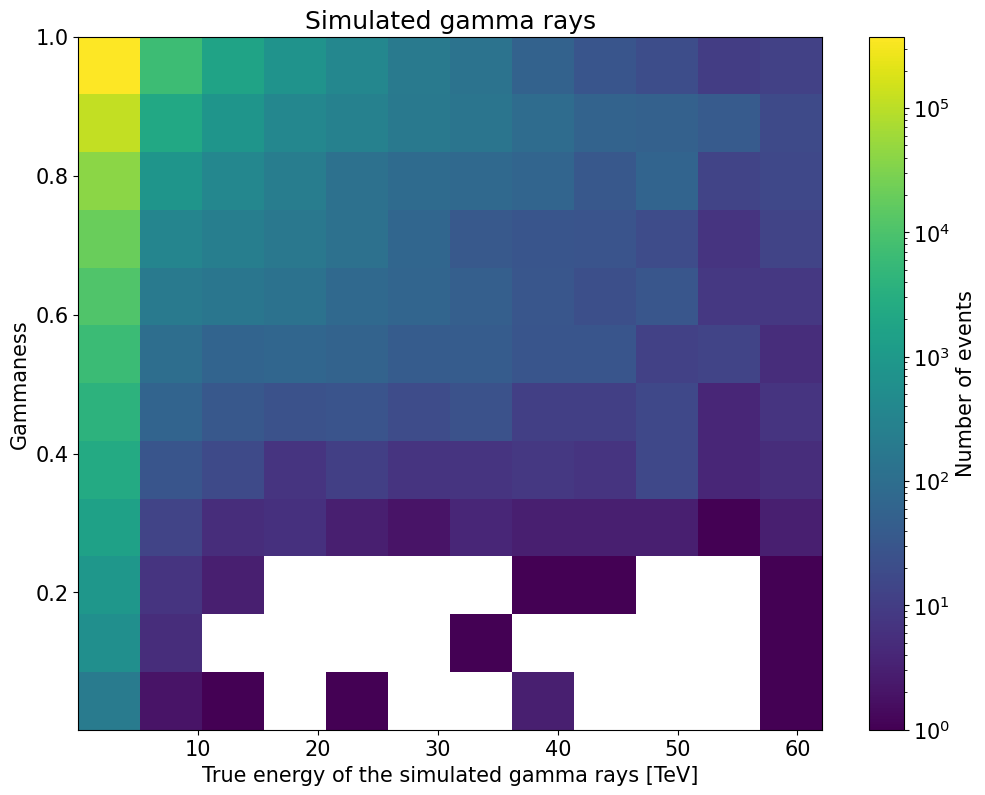

In [7]:
x=np.array(signal_hist['true_energy'].value)
y=np.array(signal_hist['gammaness'].value)
plt.figure()
plt.xlabel("True energy of the simulated gamma rays [TeV]")
plt.ylabel("Gammaness")
plt.hist2d(x,y, bins=12,  norm=mpl.colors.LogNorm())
plt.colorbar(label="Number of events")
plt.title("Simulated gamma rays")

The plot above seems quite good because most of the simulated gamma rays indeed have high values of gammaness. Now look how different is the gammaness distribution for protons:

Text(0.5, 1.0, 'Simulated protons')

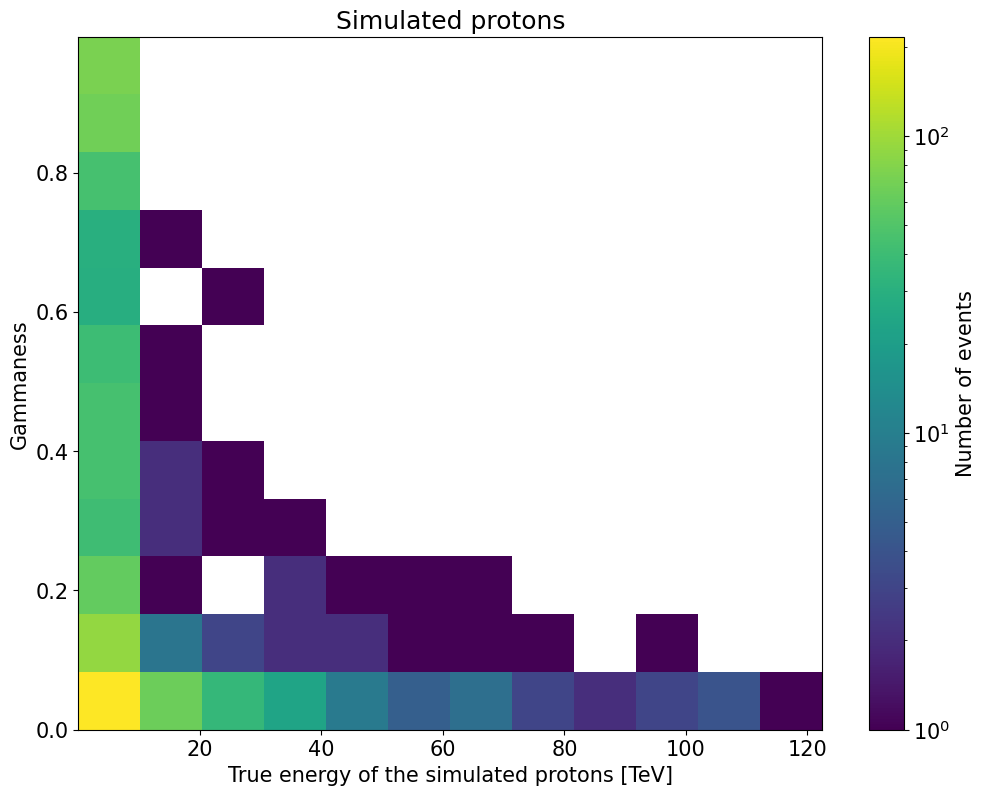

In [8]:
x=np.array(background_hist['true_energy'].value)
y=np.array(background_hist['gammaness'].value)
plt.figure()
plt.xlabel("True energy of the simulated protons [TeV]")
plt.ylabel("Gammaness")
plt.hist2d(x,y, bins=12,  norm=mpl.colors.LogNorm())
plt.colorbar(label="Number of events")
plt.title("Simulated protons")

This means that protons and gamma rays are quite well distinguished by our classification.


### Migration matrix

Now let's see if we can reasonably recover the energy of the simulated gamma rays in our classification of events. For this, we plot a migration matrix. If the classification process is well trained, the reconstructed energy of the gamma rays must be very similar to the true (simulated) energy of the simulated photons, i.e., the events must fall in a narrow region where renconstructed_energy = true_energy. And this is what we see below.

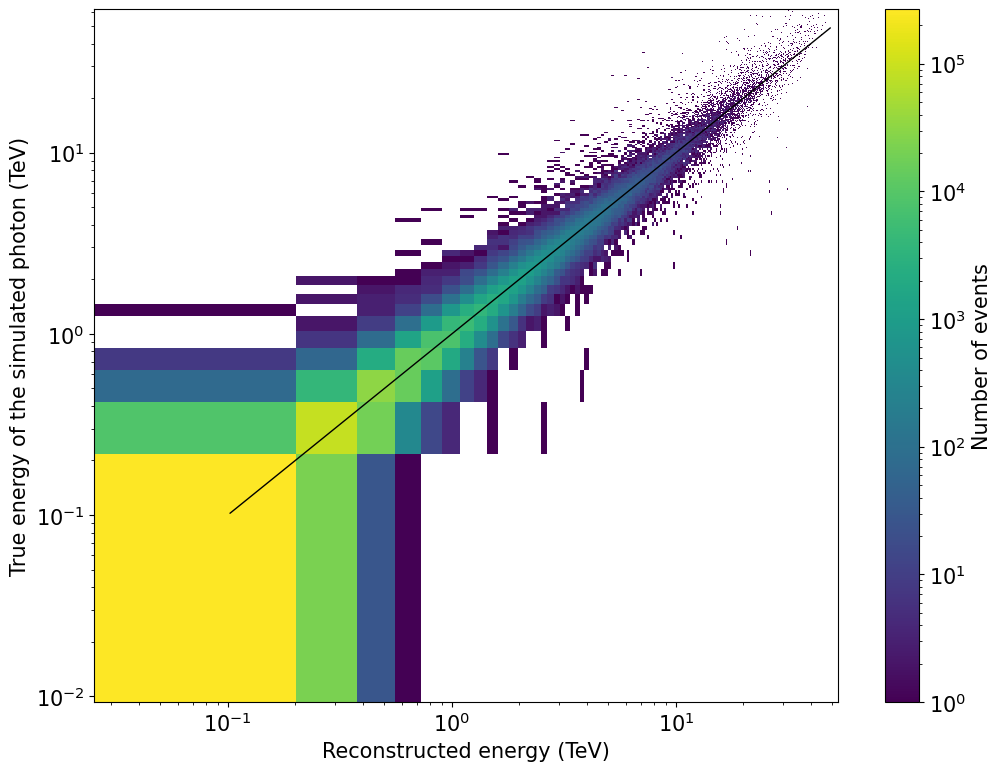

In [9]:
x=np.array(signal_hist['reco_energy'].value)
y=np.array(signal_hist['true_energy'].value)
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy (TeV)")
plt.ylabel("True energy of the simulated photon (TeV)")
plt.hist2d(x,y, bins=300,  norm=mpl.colors.LogNorm())
plt.annotate("",
              xy=(0.1,0.1), xycoords='data',
              xytext=(50,50), textcoords='data',
              arrowprops=dict(arrowstyle="-",
                              connectionstyle="arc3,rad=0."), 
              )
plt.colorbar(label="Number of events")

### Check the distribution of reconstructed energy

Here we do a sanity check just to see if most of the gamma rays identified in the classification step have relatively low energies (and they do).

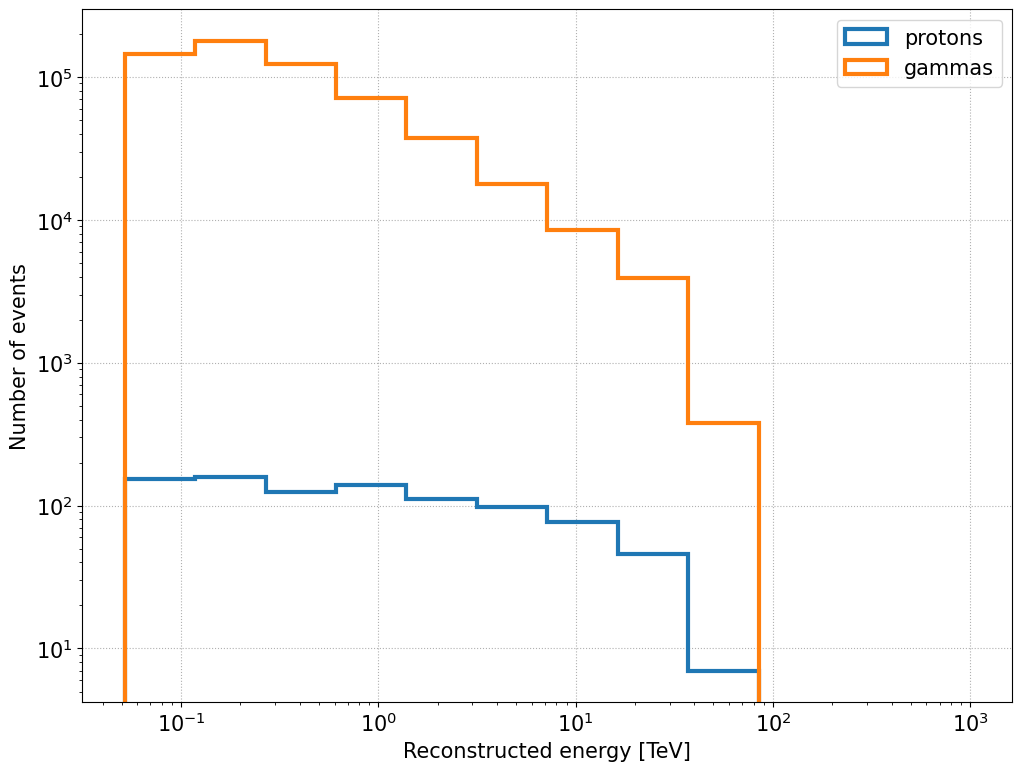

In [10]:
energy_bins_center = (energy_bins[:-1] + energy_bins[1:]) / 2

energy_bins_width = [
    energy_bins[1:] - energy_bins_center,
    energy_bins_center - energy_bins[:-1],
]
plt.figure()
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Number of events")
plt.semilogx()
plt.yscale("log")
plt.grid()
E_back=np.array(background_hist["reco_energy"].value)
E_sig=np.array(signal_hist["reco_energy"].value)
# Plot the background energy distribution
plt.hist(
    E_back,
    bins=energy_bins,
    label="protons",
    histtype="step",
    linewidth=3,
)

# Plot the signal energy distribution
plt.hist(
    E_sig,
    bins=energy_bins,
    label="gammas",
    histtype="step",
    linewidth=3,
)

plt.legend()

### Check the gammaness:

Let's do the same for the gammaness distribution: the MC gamma rays distribution must peak in 1, while the protons distribution must peak in 0, as following:

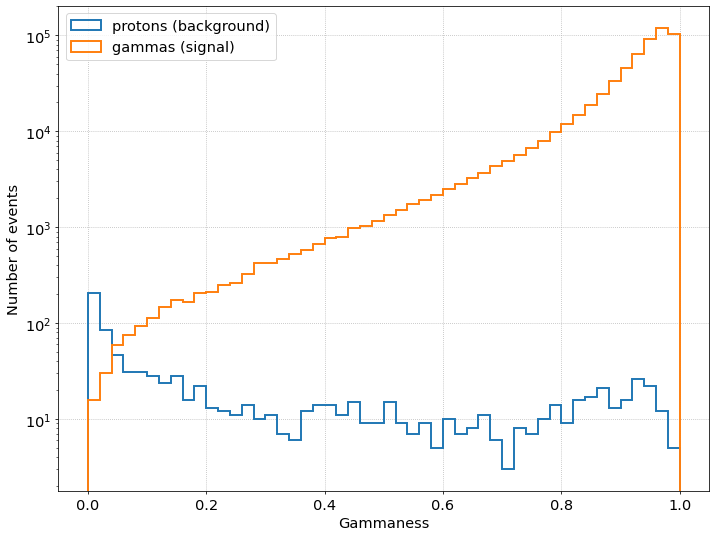

In [11]:
gh_bins = np.linspace(0, 1, 51)

plt.figure(dpi=70)
plt.xlabel("Gammaness")
plt.ylabel("Number of events")
plt.yscale("log")
plt.grid()
g_back=np.array(background_hist["gammaness"].value)
g_sig=np.array(signal_hist["gammaness"].value)
#Plot the background gammaness distribution
plt.hist(
    g_back,
    bins=gh_bins,
    label="protons (background)",
    histtype="step",
    linewidth=2,
)

# Plot the signal gammaness distribution
plt.hist(
    g_sig,
    bins=gh_bins,
    label="gammas (signal)",
    histtype="step",
    linewidth=2,
)

plt.legend(loc="upper left")


Here it is worth to notice that the gammaness increases for higher energies in the case of gamma rays, while it decreases for the protons, such that the distinction between the two types of events is easier at higher energies.

Let's do the same for different energy ranges:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


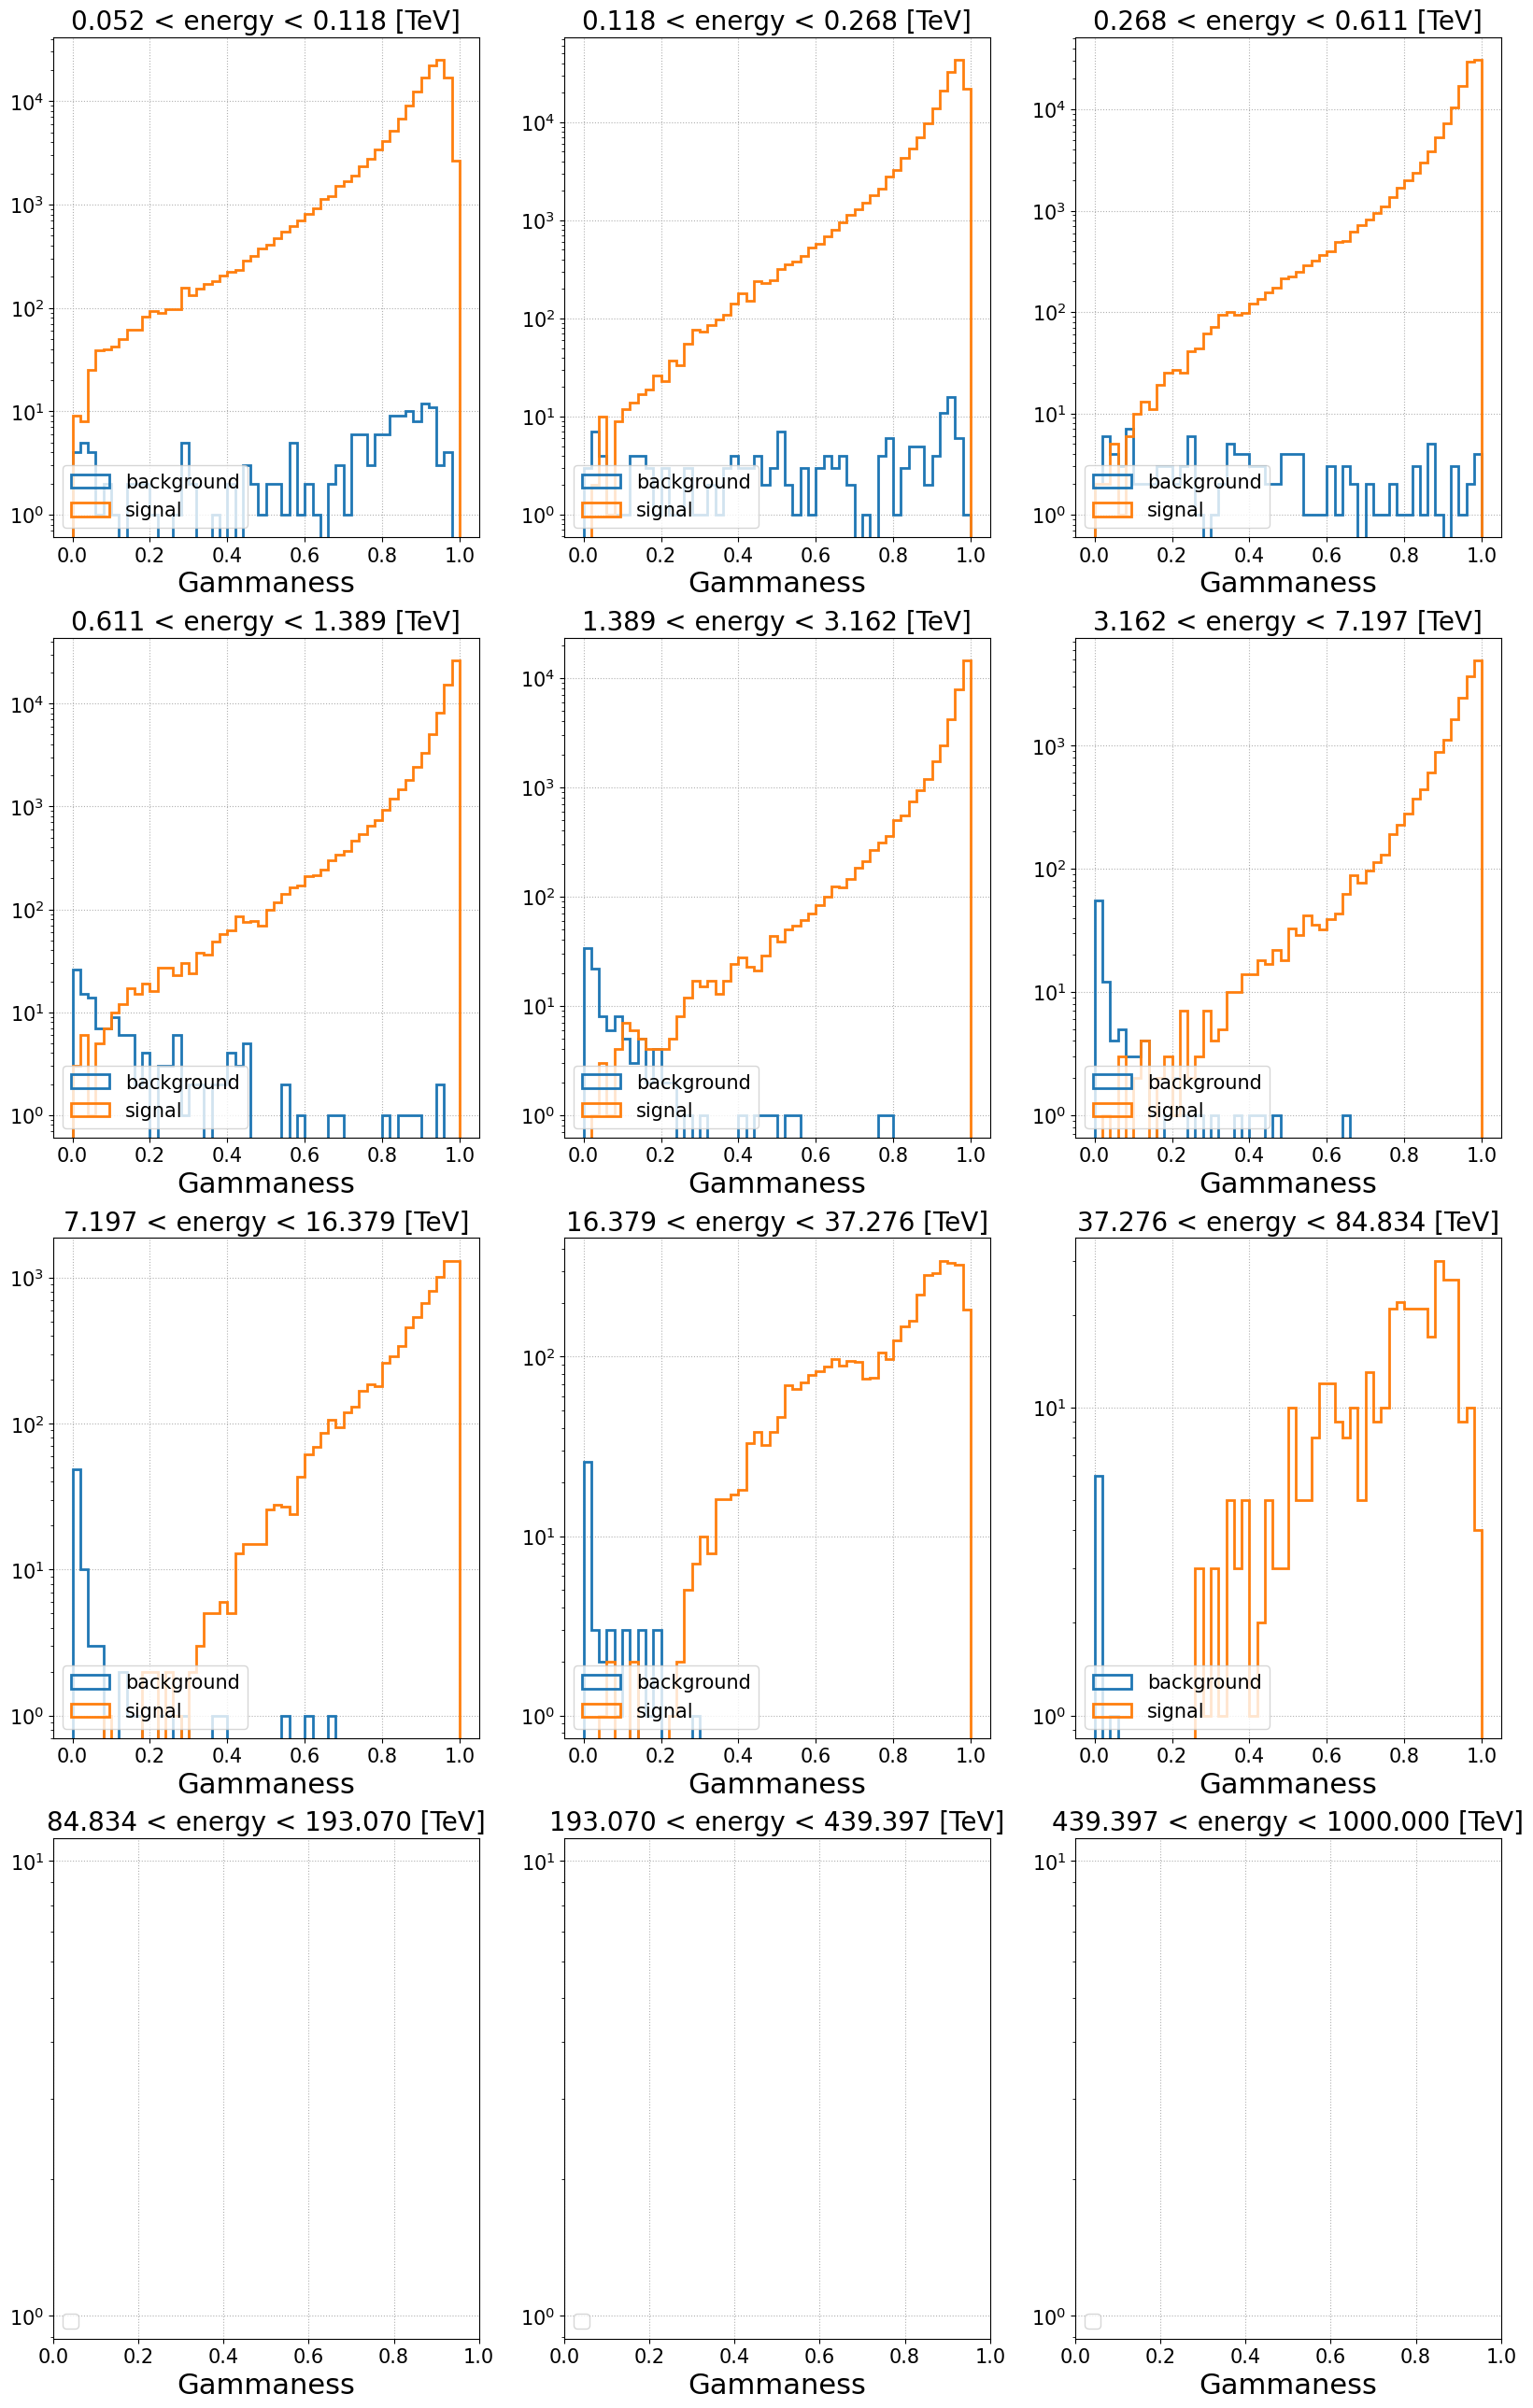

In [12]:
n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lolim:.3f} < energy < {eng_uplim:.3f} [TeV]", fontsize=20)
    plt.xlabel("Gammaness", fontsize=22)
    plt.yscale("log")
    plt.grid()

    # Apply the energy cuts
    cond_back_lolim = background_hist["reco_energy"].value > eng_lolim
    cond_back_uplim = background_hist["reco_energy"].value < eng_uplim

    cond_signal_lolim = signal_hist["reco_energy"].value > eng_lolim
    cond_signal_uplim = signal_hist["reco_energy"].value < eng_uplim

    condition_back = np.logical_and(cond_back_lolim, cond_back_uplim)
    condition_signal = np.logical_and(cond_signal_lolim, cond_signal_uplim)

    dt_back = background_hist[condition_back]
    dt_signal = signal_hist[condition_signal]

    # Plot the background gammaness distribution
    if len(dt_back) > 0:
        plt.hist(
             dt_back["gammaness"].value,
             bins=gh_bins,
             label="background",
             histtype="step",
             linewidth=2,
       )

    # Plot the signal gammaness distribution
    if len(dt_signal) > 0:
        plt.hist(
            dt_signal["gammaness"].value,
            bins=gh_bins,
            label="signal",
            histtype="step",
            linewidth=2,
        )

    plt.legend(loc="lower left")


### Apply dynamic gammaness cuts:

Now we use the function `calculate_percentile_cut()` from the module `pyirf` to evaluate dynamic (i.e. energy dependent) gammaness cuts such that we can save 90% of the gamma rays in each energy bin. 

In [13]:
gh_efficiency = 0.9
gh_percentile = 100 * (1 - gh_efficiency)


# Calculate the dynamic gammaness cuts
gh_table_eff = calculate_percentile_cut(
    values=signal_hist["gammaness"],
    bin_values=signal_hist["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=0.0,
    percentile=gh_percentile,
)

gh_cuts_eff = gh_table_eff["cut"].value
print(f"Energy bins: {energy_bins}")
print(f"Efficiency gammaness cuts:\n{gh_cuts_eff}")

Energy bins: [5.17947468e-02 1.17876863e-01 2.68269580e-01 6.10540230e-01
 1.38949549e+00 3.16227766e+00 7.19685673e+00 1.63789371e+01
 3.72759372e+01 8.48342898e+01 1.93069773e+02 4.39397056e+02
 1.00000000e+03]
Efficiency gammaness cuts:
[0.73426321 0.80252618 0.8075961  0.83209796 0.8445187  0.82590368
 0.73082502 0.54998801 0.50784547 0.         0.         0.35003833]


Gammaness cuts plot: as expected from the gammaness distributions shown above, the cut value increases for higher energies. The fall above 10 TeV, however, happens due to low statistics.

<ErrorbarContainer object of 3 artists>

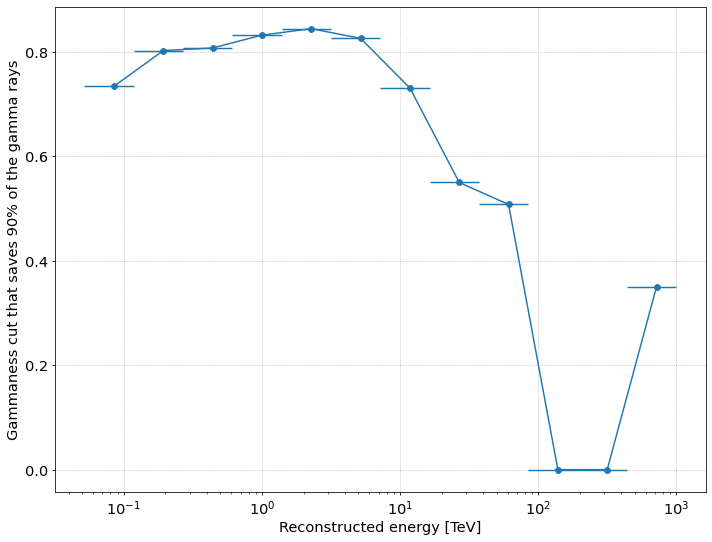

In [14]:
plt.figure(dpi=70)
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Gammaness cut that saves 90% of the gamma rays")
plt.semilogx()
plt.grid()

# Plot the dynamic gammaness cuts
plt.errorbar(
    x=energy_bins_center,
    y=gh_cuts_eff,
    xerr=energy_bins_width,
    label="gamma efficiency",
    marker="o",
)

Now we apply these gammaness cuts to our (gammas) datasets, such that we end up with a relatively pure sample of gamma rays.

In [19]:
print("\nApplying the gammaness cuts...")


mask_gh_eff = evaluate_binned_cut(
    values=signal_hist["gammaness"],
    bin_values=signal_hist["reco_energy"],
    cut_table=gh_table_eff,
    op=operator.ge,
)

data_eff_gcut = signal_hist[mask_gh_eff]
print(f"--> Number of events: {len(data_eff_gcut)}")


mask_gh_eff_26 = evaluate_binned_cut(
    values=signal_hist_6_26["gammaness"],
    bin_values=signal_hist_6_26["reco_energy"],
    cut_table=gh_table_eff,
    op=operator.ge,
)

data_eff_gcut_26 = signal_hist_6_26[mask_gh_eff_26]
  
"""    
mask_gh_eff_46 = evaluate_binned_cut(
    values=signal_hist_26_46["gammaness"],
    bin_values=signal_hist_26_46["reco_energy"],
    cut_table=gh_table_eff,
    op=operator.ge,
)

data_eff_gcut_46 = signal_hist_26_46[mask_gh_eff_46]



mask_gh_eff_67 = evaluate_binned_cut(
    values=signal_hist_46_67["gammaness"],
    bin_values=signal_hist_46_67["reco_energy"],
    cut_table=gh_table_eff,
    op=operator.ge,
)

data_eff_gcut_67 = signal_hist_46_67[mask_gh_eff_67]
"""



Applying the gammaness cuts...
--> Number of events: 535872


'    \nmask_gh_eff_46 = evaluate_binned_cut(\n    values=signal_hist_26_46["gammaness"],\n    bin_values=signal_hist_26_46["reco_energy"],\n    cut_table=gh_table_eff,\n    op=operator.ge,\n)\n\ndata_eff_gcut_46 = signal_hist_26_46[mask_gh_eff_46]\n\n\n\nmask_gh_eff_67 = evaluate_binned_cut(\n    values=signal_hist_46_67["gammaness"],\n    bin_values=signal_hist_46_67["reco_energy"],\n    cut_table=gh_table_eff,\n    op=operator.ge,\n)\n\ndata_eff_gcut_67 = signal_hist_46_67[mask_gh_eff_67]\n'

### Check the reconstructed direction:

We want that the $\theta^2$ distribution of the gamma rays to have a peak in 0, i.e. the reconstructed direction is equal to the real one. Don't forget that $\theta$ is the offset angle between the real position of the target and the reconstructed position for a single event, as in the figure below:

![theta](./figures/theta.png)


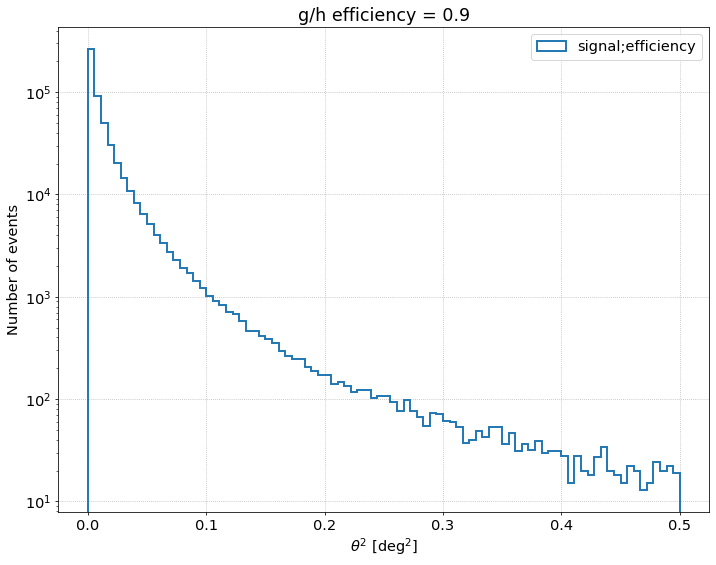

In [23]:
# ================
# === Settings ===
# ================

theta2_bins = np.linspace(0, 0.5, 91)
yscale = "log"

# ============
# === Main ===
# ============

plt.figure(dpi=70)
plt.title(f"g/h efficiency = {gh_efficiency}")
plt.xlabel(r"$\theta^2$ [deg$^2$]")
plt.ylabel("Number of events")
plt.yscale(yscale)
plt.grid()



eff_gcut=np.array(data_eff_gcut["theta"].value)

# Plot the signal theta2 distribution
plt.hist(
    np.square(eff_gcut),
    bins=theta2_bins,
    label="signal;efficiency",
    histtype="step",
    linewidth=2,
)

plt.legend()


Let's do the same for different energy bins. We see that the higer the energy, the better is the reconstructed direction.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


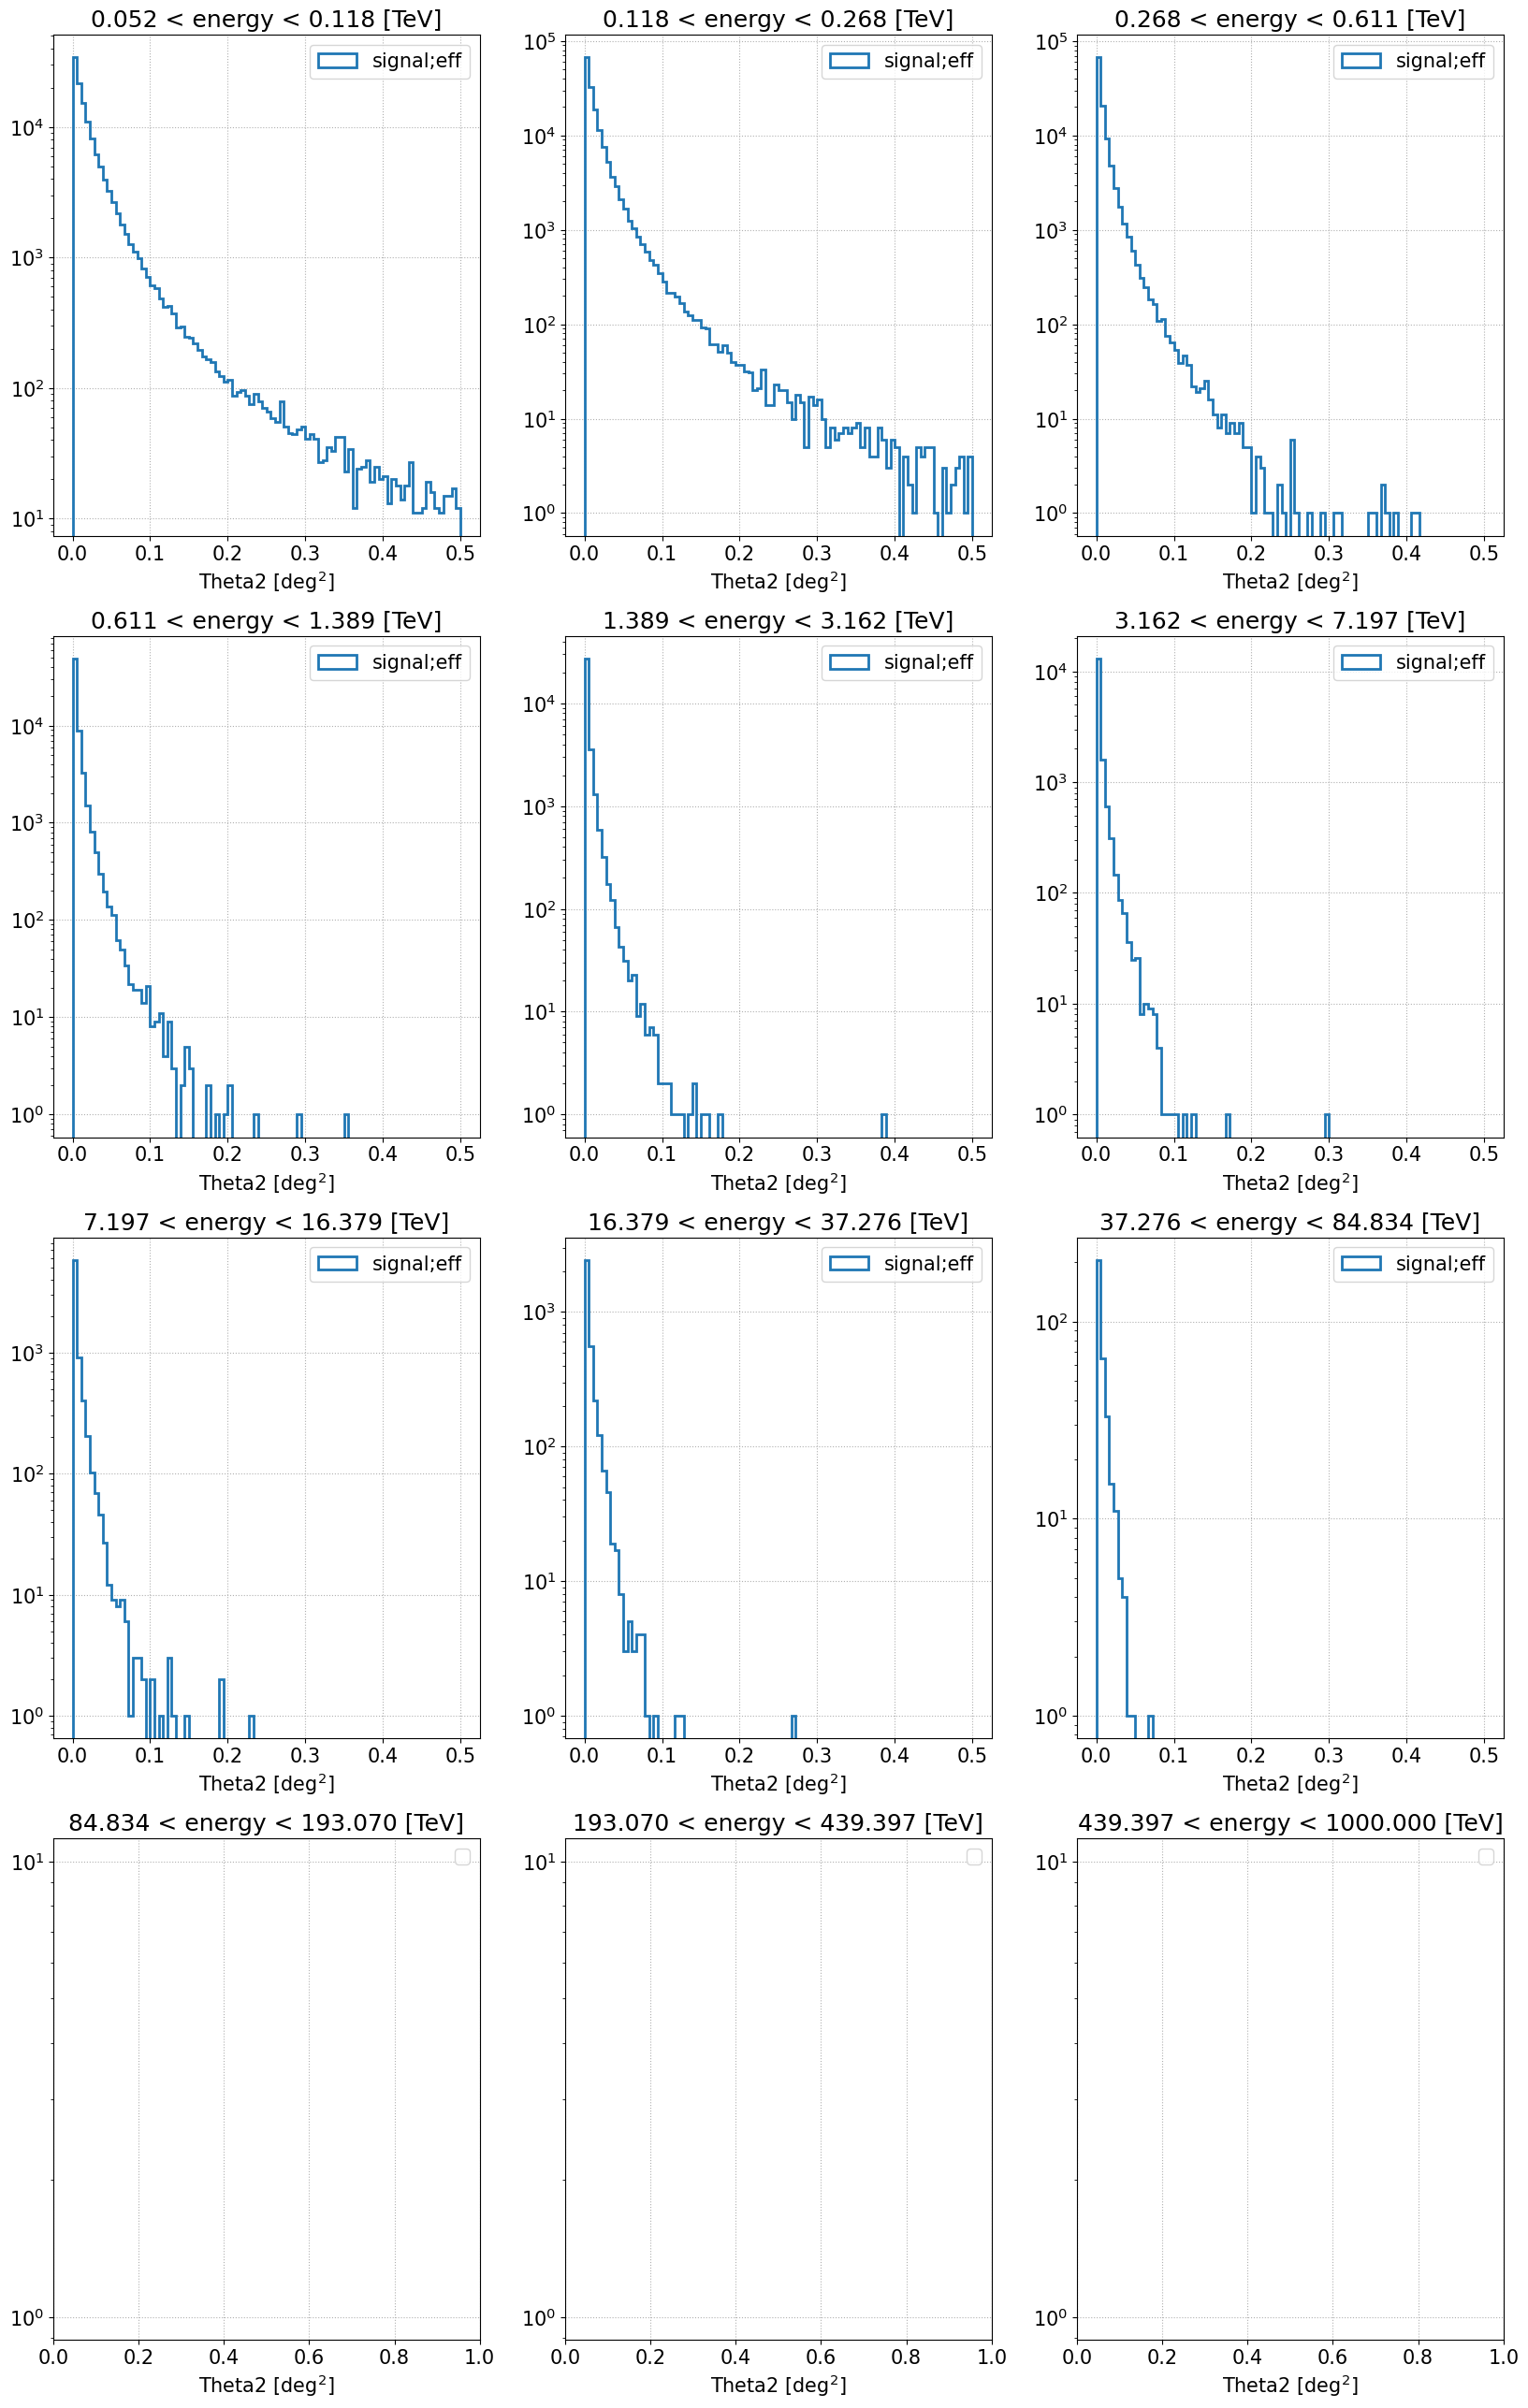

In [24]:
n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lolim:.3f} < energy < {eng_uplim:.3f} [TeV]")
    plt.xlabel("Theta2 [deg$^2$]")
    plt.yscale(yscale)
    plt.grid()

    # Apply the energy cuts
    cond_eff_lolim = data_eff_gcut["reco_energy"].value > eng_lolim
    cond_eff_uplim = data_eff_gcut["reco_energy"].value < eng_uplim

    
    
    condition_eff = np.logical_and(cond_eff_lolim, cond_eff_uplim)

    
    dt_eff = data_eff_gcut[condition_eff]
    dte=np.array(dt_eff["theta"].value)
    
    # Plot the theta2 distribution
    if len(dt_eff) > 0:
        plt.hist(
            np.square(dte),
            bins=theta2_bins,
            label="signal;eff",
            histtype="step",
            linewidth=2,
        )

    plt.legend(loc="upper right")


### Check the angular resolution:

We now use the `angular_resolution()` function from `pyirf` to evaluate the angular resolution, which is defined as the $\theta$ value under which we can find 68% of the events. We also notice that the angular resolution gets better at higher energies.

In [27]:
# Calculate the angular resolution
angres_table_eff = angular_resolution(
    data_eff_gcut, u.Quantity(energy_bins, u.TeV), energy_type="reco"
)

angres_eff = angres_table_eff["angular_resolution"].value
print(f"\n angular resolution:\n{angres_eff} deg")




 angular resolution:
[0.16335789 0.11826872 0.08565964 0.06523903 0.05551106 0.05469117
 0.06272274 0.07295256 0.08561091        nan        nan        nan] deg


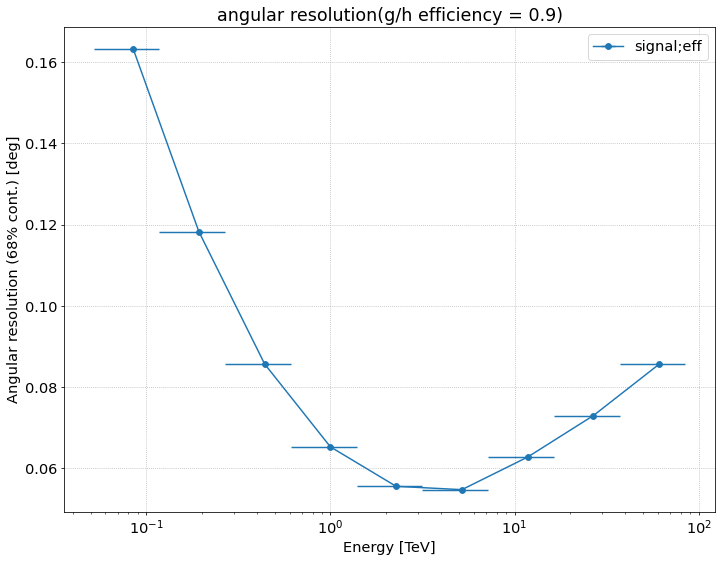

In [28]:
plt.figure(dpi=70)
gs = gridspec.GridSpec(4, 1)

plt.title(f"angular resolution(g/h efficiency = {gh_efficiency})")
plt.ylabel("Angular resolution (68% cont.) [deg]")
plt.xlabel("Energy [TeV]")
plt.semilogx()
plt.grid()

# Plot the angular resolution
plt.errorbar(
    x=energy_bins_center,
    y=angres_eff,
    xerr=energy_bins_width,
    label="signal;eff",
    marker="o",
)


plt.legend()


# Apply dynamic theta cuts

In [132]:
# ================
# === Settings ===
# ================
theta_efficiency_68=0.68
theta_efficiency = 0.8

# ============
# === Main ===
# ============



theta_percentile = 100 * theta_efficiency
theta_percentile_68 = 100 * theta_efficiency_68


# Calculate the dynamic theta cuts
theta_table_eff = calculate_percentile_cut(
    values=data_eff_gcut["theta"],
    bin_values=data_eff_gcut["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=data_eff_gcut["theta"].unmasked.max(),
    percentile=theta_percentile,
)
theta_table_eff_68= calculate_percentile_cut(
    values=data_eff_gcut["theta"],
    bin_values=data_eff_gcut["reco_energy"],
    bins=u.Quantity(energy_bins, u.TeV),
    fill_value=data_eff_gcut["theta"].unmasked.max(),
    percentile=theta_percentile_68,
)

theta_cuts_eff = theta_table_eff["cut"]
theta_cuts_eff_68 = theta_table_eff_68["cut"]

theta_cut_eff = theta_table_eff["cut"].value
theta_cut_eff_68 = theta_table_eff_68["cut"].value
print(f"\n(0.8 efficiency) theta cuts:\n{theta_cuts_eff}")
print(f"\n(0.68 efficiency) theta cuts:\n{theta_cuts_eff_68}")


(0.8 efficiency) theta cuts:
[0.23285819 0.19393156 0.15534828 0.1177449  0.09222395 0.07855285
 0.07393113 0.07662622 0.08363195 0.09312991 0.10274031 0.09594897] deg

(0.68 efficiency) theta cuts:
[0.18231324 0.151274   0.12121779 0.0922895  0.07212109 0.06092443
 0.0564142  0.05719697 0.06201013 0.07093644 0.07760683 0.07661635] deg


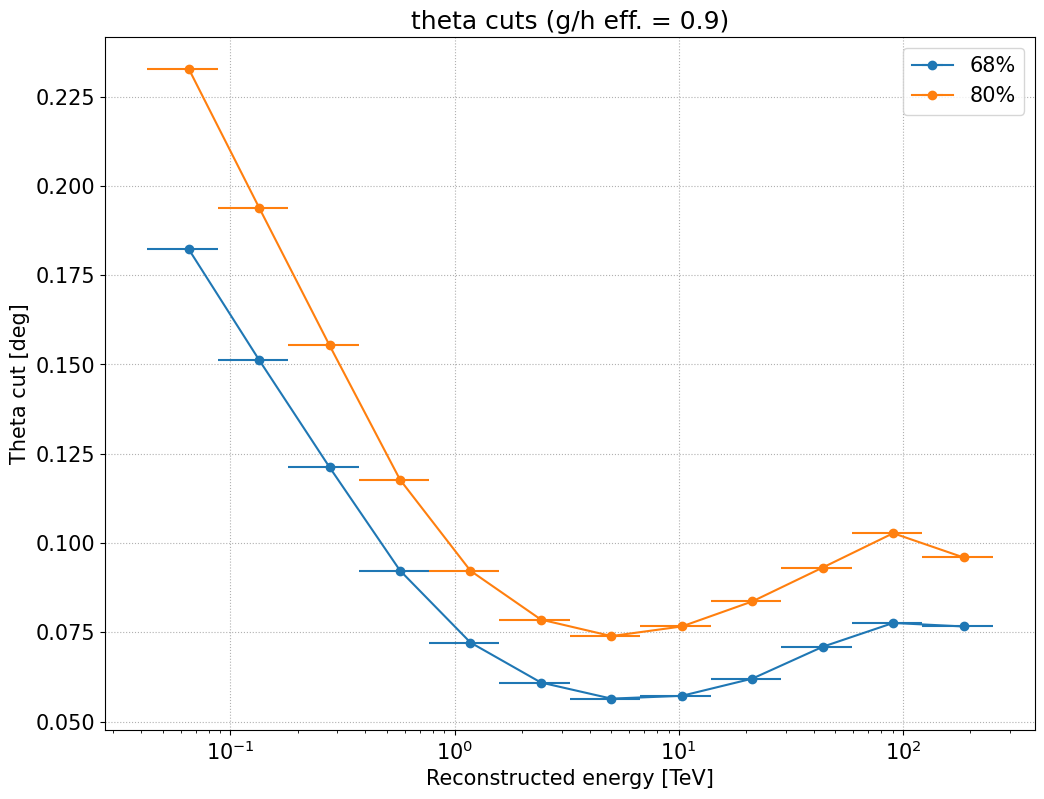

In [133]:
plt.figure()
plt.title(f"theta cuts (g/h eff. = {gh_efficiency})")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Theta cut [deg]")
plt.semilogx()
plt.grid()

# Plot the 68% dynamic theta cuts
plt.errorbar(
    x=energy_bins_center,
    y=theta_cuts_eff_68,
    xerr=energy_bins_width,
    label="68%",
    marker="o",
)

# Plot the 80% dynamic theta cuts
plt.errorbar(
    x=energy_bins_center,
    y=theta_cuts_eff,
    xerr=energy_bins_width,
    label="80%",
    marker="o",
)

plt.legend(loc="upper right")


In [134]:



# Apply dynamic theta cuts
print("\nApplying the theta cuts to signal;eff...")

mask_theta_eff = evaluate_binned_cut(
    values=data_eff_gcut["theta"],
    bin_values=data_eff_gcut["reco_energy"],
    cut_table=theta_table_eff,
    op=operator.le,
)

data_eff_gtcuts = data_eff_gcut[mask_theta_eff]
print(f"--> Number of events: {len(data_eff_gtcuts)}")


Applying the theta cuts to signal;eff...
--> Number of events: 1929733


In [135]:
# Apply dynamic theta cuts
print("\nApplying the theta cuts to signal;eff...")

mask_theta_eff_26 = evaluate_binned_cut(
    values=data_eff_gcut_26["theta"],
    bin_values=data_eff_gcut_26["reco_energy"],
    cut_table=theta_table_eff,
    op=operator.le,
)

data_eff_gtcuts_26 = data_eff_gcut_26[mask_theta_eff_26]
print(f"--> Number of events: {len(data_eff_gtcuts)}")


Applying the theta cuts to signal;eff...
--> Number of events: 1929733


In [136]:
# Apply dynamic theta cuts
print("\nApplying the theta cuts to signal;eff...")

mask_theta_eff_46 = evaluate_binned_cut(
    values=data_eff_gcut_46["theta"],
    bin_values=data_eff_gcut_46["reco_energy"],
    cut_table=theta_table_eff,
    op=operator.le,
)

data_eff_gtcuts_46 = data_eff_gcut_46[mask_theta_eff_46]
print(f"--> Number of events: {len(data_eff_gtcuts)}")


Applying the theta cuts to signal;eff...
--> Number of events: 1929733


In [137]:
# Apply dynamic theta cuts
print("\nApplying the theta cuts to signal;eff...")

mask_theta_eff_67 = evaluate_binned_cut(
    values=data_eff_gcut_67["theta"],
    bin_values=data_eff_gcut_67["reco_energy"],
    cut_table=theta_table_eff,
    op=operator.le,
)

data_eff_gtcuts_67 = data_eff_gcut_67[mask_theta_eff_67]
print(f"--> Number of events: {len(data_eff_gtcuts)}")


Applying the theta cuts to signal;eff...
--> Number of events: 1929733


# Check the effective area

Warning: effective area depends on azimuth: MCs with azimuth in a narrow range (~30 deg) must be provided as imput or you will get meaningless results

In [138]:


# Calculate the low zenith effective area
aeff_eff_26 = effective_area_per_energy(
    selected_events=data_eff_gtcuts_26,
    simulation_info=sim_isto_signal,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print(f"\neffective area:\n{aeff_eff_26}")


effective area:
[ 13106.98291489  49712.51096374  89184.93729777 126340.64127018
 156745.67972771 172303.87242138 181667.58711056 174558.81670413
 158396.28990413 132296.38568133   5584.3049413       0.        ] m2


In [139]:

# Calculate the mid zenith effective area
aeff_eff_46 = effective_area_per_energy(
    selected_events=data_eff_gtcuts_46,
    simulation_info=sim_isto_signal,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print(f"\neffective area:\n{aeff_eff_46}")


effective area:
[  8018.79853462  74251.16690859 193947.01476714 301815.90736989
 392152.99585078 466118.5659713  510389.85003132 544441.33763128
 554649.69507891 530675.06190906 341201.03191358      0.        ] m2


In [140]:


# Calculate the high zenith effective area
aeff_eff_67 = effective_area_per_energy(
    selected_events=data_eff_gtcuts_67,
    simulation_info=sim_isto_signal,
    true_energy_bins=u.Quantity(energy_bins, u.TeV),
)

print(f"\neffective area:\n{aeff_eff_67}")


effective area:
[3.55475620e+02 1.97413077e+04 1.36598157e+05 2.75115141e+05
 3.95055492e+05 5.10424848e+05 5.98613388e+05 6.82374969e+05
 7.53367429e+05 8.01361321e+05 7.51089015e+05 4.28742147e+05] m2


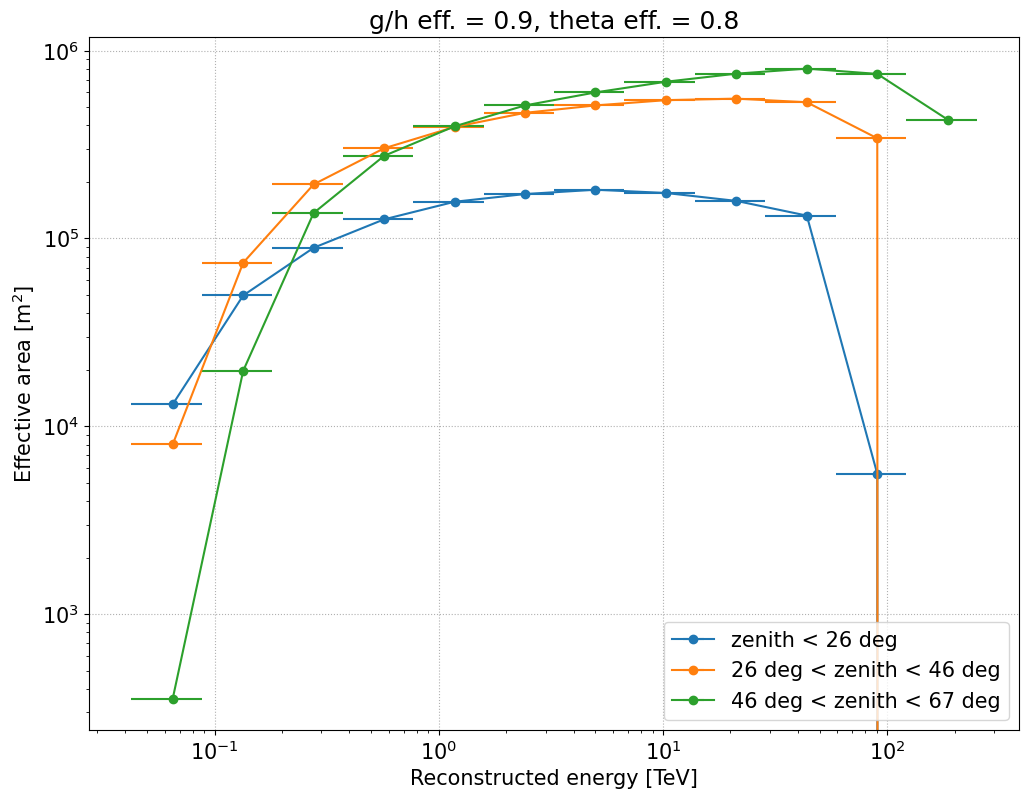

In [141]:
plt.figure()
plt.title(f"g/h eff. = {gh_efficiency}, theta eff. = {theta_efficiency}")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Effective area [m$^2$]")
plt.loglog()
plt.grid()


# Plot the effective area
plt.errorbar(
    x=energy_bins_center,
    y=aeff_eff_26.value,
    xerr=energy_bins_width,
    label="zenith < 26 deg",
    marker="o",
)


# Plot the effective area
plt.errorbar(
    x=energy_bins_center,
    y=aeff_eff_46.value,
    xerr=energy_bins_width,
    label="26 deg < zenith < 46 deg",
    marker="o",
)



# Plot the effective area
plt.errorbar(
    x=energy_bins_center,
    y=aeff_eff_67.value,
    xerr=energy_bins_width,
    label="46 deg < zenith < 67 deg",
    marker="o",
)

plt.legend(loc="lower right")


# Check the energy bias and resolution

In [142]:



# Calculate the  signal energy bias and resolution
engres_table_eff = energy_bias_resolution(
    data_eff_gtcuts, u.Quantity(energy_bins, u.TeV), energy_type="reco"
)

engbias_eff = engres_table_eff["bias"].value
engres_eff = engres_table_eff["resolution"].value

print(
    f"\n signal energy bias:\n{engbias_eff}"
    f"\n\n signal energy resolution:\n{engres_eff}"
)




 signal energy bias:
[ 0.12121256  0.05161536  0.02034073 -0.00625864 -0.01083733 -0.01901826
 -0.02245983 -0.01480609 -0.02816956 -0.04206868 -0.0849906  -0.12575247]

 signal energy resolution:
[0.27012496 0.22982749 0.20194219 0.16243838 0.13982065 0.12613251
 0.12159538 0.12552919 0.13659191 0.15717099 0.1587814  0.08574008]


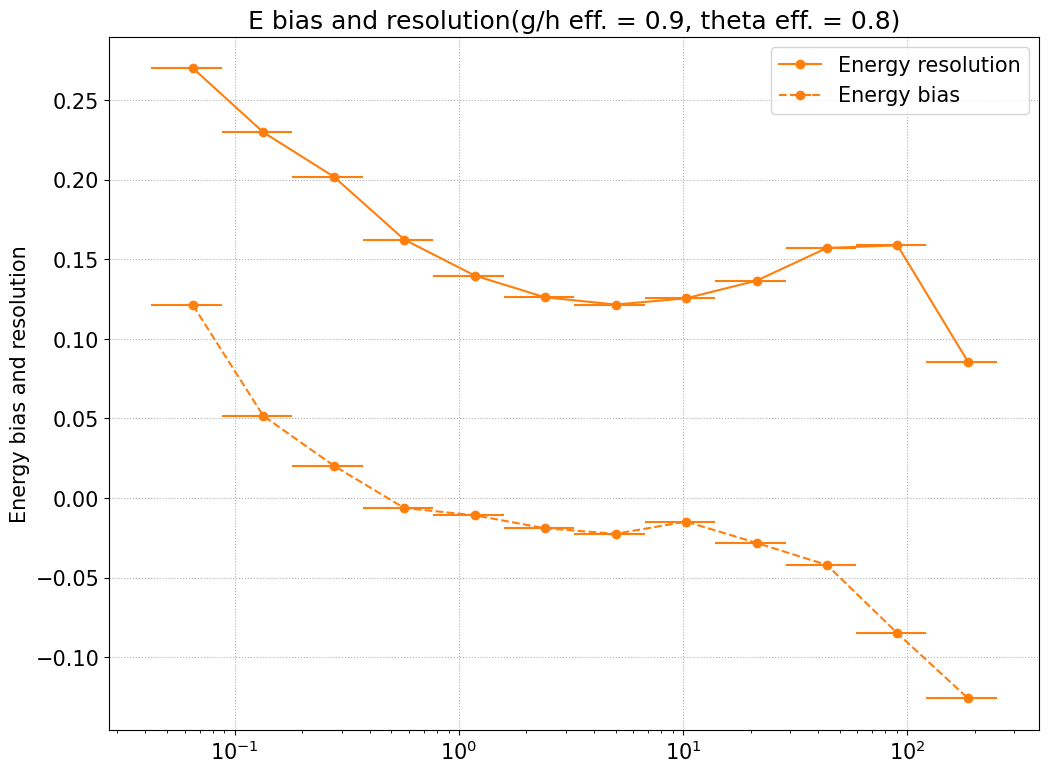

In [143]:
plt.figure()
gs = gridspec.GridSpec(4, 1)


plt.title(f"E bias and resolution(g/h eff. = {gh_efficiency}, theta eff. = {theta_efficiency})")
plt.ylabel("Energy bias and resolution")
plt.semilogx()
plt.grid()





# Plot the signal energy bias and resolution
plt.errorbar(
    x=energy_bins_center,
    y=engres_eff,
    xerr=energy_bins_width,
    label="Energy resolution",
    marker="o",
    color=colors[1],
)

plt.errorbar(
    x=energy_bins_center,
    y=engbias_eff,
    xerr=energy_bins_width,
    label="Energy bias",
    marker="o",
    linestyle="--",
    color=colors[1],
)


plt.legend()


# Plots: cut effects on background

In [144]:

back_gn_cut_eff=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    mask_table_eff=(background_hist["reco_energy"].value >np.repeat(eng_lo,(len(background_hist)))) \
        & (background_hist["reco_energy"].value <np.repeat(eng_hi,(len(background_hist)))) \
            & (background_hist["gammaness"].value>np.repeat(gh_table_eff['cut'][i_bin],(len(background_hist))))
    back_masked_gn_eff=background_hist[mask_table_eff]
    back_gn_cut_eff=vstack([back_masked_gn_eff,back_gn_cut_eff])
    print(len(back_masked_gn_eff))
print("tot",len(back_gn_cut_eff))
back_gn_cut_eff

183
450
382
179
61
10
3
0
0
1
1
0
tot 1270


col0,obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,92501,5493302,3,3,77.18590545654297,37.32893041803314,277.13284919575966,0.6603977193615884,4.845313076623008,60.617401274400954,37.2239412741617,277.18444276069033,0.6825116344300607,0.1127304913564464,0.6369789442475938,0.702984235705642
--,87002,3748002,3,3,47.265472412109375,52.345149119630356,271.51346132029346,0.9134878932659566,4.7239255901298804,34.6029803841377,52.275701726721636,271.4879386807648,0.5896201798496663,0.07117884820674207,0.5208415575674664,0.5095560220957415
--,26902,5255206,3,3,6.527000904083252,51.771327851984665,270.8023839861817,0.9134878932659566,4.7239255901298804,4.425961826856665,51.71442821535641,270.8426659888898,0.8568430448193042,0.062126366973424,0.574291346478239,0.6344956853889673
--,87503,274405,3,3,5.101036548614502,45.118860204175654,274.19690604140806,0.7866722022187959,4.787158965217607,3.5676866387001382,45.11659169754801,274.169227414456,0.9728299889130265,0.019662787056279628,0.07670595249107873,0.09200865531200682
--,71401,5080200,3,3,6.497277736663818,37.93415006529338,278.17797742179835,0.6603977193615884,4.845313076623008,5.864718416508384,38.01670181994362,278.20788540336207,0.9733341271838447,0.08585223262715325,0.45384021239726763,0.49991100182539294
--,42302,2449009,3,3,3.383066177368164,52.79666901999781,270.1802630358203,0.9134878932659566,4.7239255901298804,2.2568436422270417,52.69806507781018,270.0943052321234,0.9541473461732581,0.11149060133495087,0.5429906815242801,0.4978311743173047
--,81701,4433607,3,3,3.0971288681030273,36.66077740776039,276.70943210873224,0.6603977193615884,4.845313076623008,2.4036786634712075,36.75507825093736,276.7297069574425,0.9643953867432487,0.09569142064283367,1.3807788405160772,1.2921961846200487
--,86901,3324907,3,3,3.6102468967437744,37.20945674907127,275.5057342109226,0.6603977193615884,4.845313076623008,1.765830922265535,37.22885325259242,275.5940555035927,0.8380471421605012,0.07295828922686673,1.7877262505461238,1.7151545900918352


In [145]:

ttheta_table_eff=Table(theta_table_eff)
ttheta_table_eff_68=Table(theta_table_eff_68)

In [146]:
#theta 68%,eff
back_theta_cut_eff_68=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    mask_table_theta_eff_68=(back_gn_cut_eff["reco_energy"].value >np.repeat(eng_lo,(len(back_gn_cut_eff)))) \
        & (back_gn_cut_eff["reco_energy"].value <np.repeat(eng_hi,(len(back_gn_cut_eff)))) \
            & (back_gn_cut_eff["theta"].value < np.repeat(theta_cut_eff_68[i_bin],(len(back_gn_cut_eff))))
    back_masked_theta_eff_68=back_gn_cut_eff[mask_table_theta_eff_68]
    back_theta_cut_eff_68=vstack([back_masked_theta_eff_68,back_theta_cut_eff_68])
    print(len(back_masked_theta_eff_68))
print("tot",len(back_theta_cut_eff_68))

11
72
61
41
16
1
1
0
0
0
0
0
tot 203


In [147]:
#theta 80%,eff
back_theta_cut_eff_80=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    mask_table_theta_eff_80=(back_gn_cut_eff["reco_energy"].value >np.repeat(eng_lo,(len(back_gn_cut_eff)))) \
        & (back_gn_cut_eff["reco_energy"].value <np.repeat(eng_hi,(len(back_gn_cut_eff)))) \
            & (back_gn_cut_eff["theta"].value < np.repeat(theta_cut_eff[i_bin],(len(back_gn_cut_eff))))
    back_masked_theta_eff_80=back_gn_cut_eff[mask_table_theta_eff_80]
    back_theta_cut_eff_80=vstack([back_masked_theta_eff_80,back_theta_cut_eff_80])
    print(len(back_masked_theta_eff_80))
print("tot",len(back_theta_cut_eff_80))

17
92
100
65
24
2
2
0
0
1
0
0
tot 303


Plot

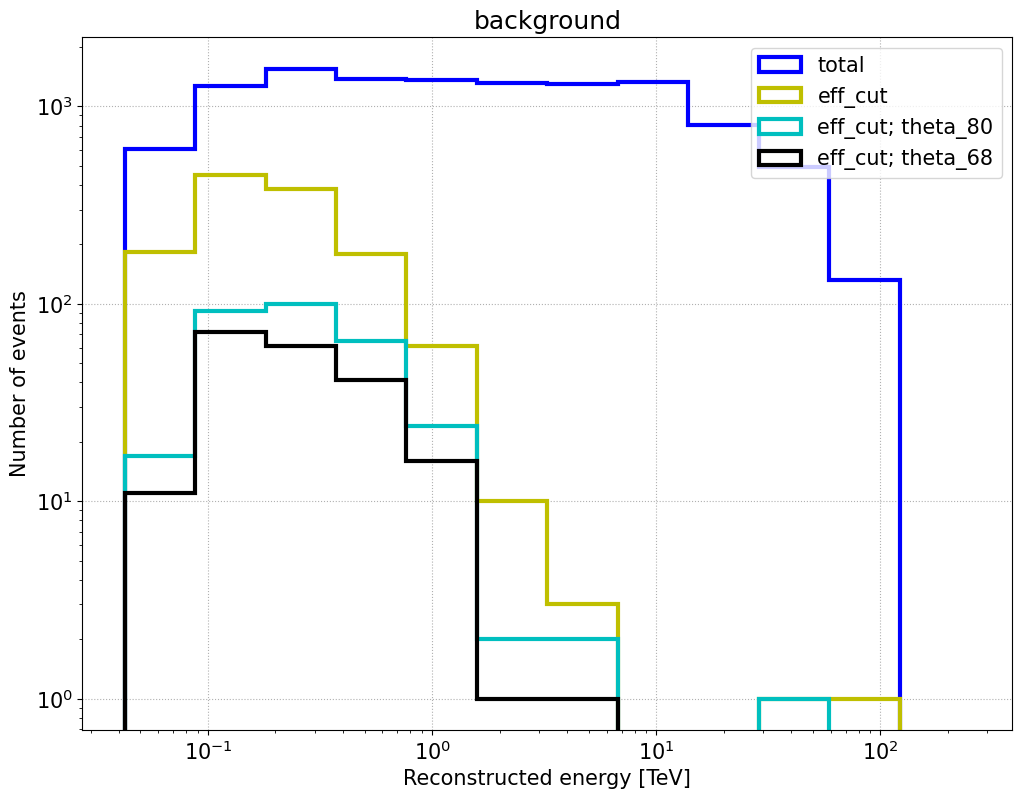

In [148]:
plt.figure()
plt.title("background")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Number of events")
plt.semilogx()
plt.yscale(yscale)
plt.grid()

theta_80_eff=np.array(back_theta_cut_eff_80["reco_energy"].value)
theta_68_eff=np.array(back_theta_cut_eff_68["reco_energy"].value)
gn_eff=np.array(back_gn_cut_eff["reco_energy"].value)
tot_back=np.array(background_hist["reco_energy"].value)
# before cuts
plt.hist(
    tot_back,
    bins=energy_bins,
    label="total",
    histtype="step",
    linewidth=3,
    color="b"
)




#gammaness cut
plt.hist(
    gn_eff,
    bins=energy_bins,
    label="eff_cut",
    histtype="step",
    linewidth=3,
    color="y"
)


#theta 80%, eff
plt.hist(
    theta_80_eff,
    bins=energy_bins,
    label="eff_cut; theta_80",
    histtype="step",
    linewidth=3,
    color="c"
)
#theta 68%, eff
plt.hist(
    theta_68_eff,
    bins=energy_bins,
    label="eff_cut; theta_68",
    histtype="step",
    linewidth=3,
    color="k"
)


plt.legend()



# Plots: cut effects on signal

In [149]:


sig_gn_cut_eff=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    mask_E=np.logical_and((signal_hist["reco_energy"].value >np.repeat(eng_lo,(len(signal_hist)))), \
        (signal_hist["reco_energy"].value <np.repeat(eng_hi,(len(signal_hist)))))
    mask_table_eff_sig=np.logical_and(mask_E,(signal_hist["gammaness"].value>np.repeat(gh_table_eff['cut'][i_bin],(len(signal_hist)))))
    sig_masked_gn_eff=signal_hist[mask_table_eff_sig]
    sig_gn_cut_eff=vstack([sig_masked_gn_eff,sig_gn_cut_eff])
    print(len(sig_masked_gn_eff))
print("tot",len(sig_gn_cut_eff))
sig_gn_cut_eff

96934
449314
660021
499815
318654
186995
101169
53699
27525
13494
4343
55
tot 2412018


col0,obs_id,event_id,combo_type,multiplicity,true_energy,true_alt,true_az,pointing_alt,pointing_az,reco_energy,reco_alt,reco_az,gammaness,theta,true_source_fov_offset,reco_source_fov_offset
,,,,,TeV,deg,deg,rad,rad,TeV,deg,deg,,deg,deg,deg
float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
--,1002,930509,3,3,157.12496948242188,37.59423887105853,239.4967583405619,0.6566975765880042,4.188859942727806,128.43188840926803,37.599535818944815,239.5401523352322,0.8459730899215935,0.03478768541307871,0.4030769783391559,0.36838659344474406
--,1502,1146607,3,3,155.84080505371094,37.819522415547645,239.5573830996349,0.6566975765880042,4.188859942727806,128.4423812535383,37.8562991060153,239.55754461532112,0.9495821955914705,0.03677691167723402,0.40279582449450385,0.4215198181191885
--,2802,1672608,3,3,156.93263244628906,38.01667582594006,239.8917891613988,0.6566975765880042,4.188859942727806,122.0196894612456,38.00525546855976,239.9395658359088,0.7567905342257653,0.03933716654822683,0.4006045601838369,0.3826561238306678
--,3502,901104,3,3,158.81967163085938,37.79213677207048,239.54008906065647,0.6566975765880042,4.188859942727806,135.38146705093413,37.78126702065471,239.506467861121,0.8719225030604766,0.02870811344545746,0.4028605172980429,0.4231512702975662
--,3602,1967309,3,3,112.66860961914062,37.404199102686675,239.58041449751622,0.6566975765880042,4.188859942727806,129.0377691830859,37.39937566890677,239.53653423053592,0.8039791769530932,0.035190427166666545,0.4025897251832043,0.4345682550154261
--,4102,1845600,3,3,148.3280029296875,37.44532708677391,239.549951853818,0.6566975765880042,4.188859942727806,130.88443384758205,37.416291165816965,239.58965735677998,0.893852088013909,0.042862618636174424,0.40283302955205647,0.38983402091381986
--,4302,1782901,3,3,159.7802276611328,38.02490961898451,239.9636427514673,0.6566975765880042,4.188859942727806,139.99102177375778,38.05731373144403,239.97302934088415,0.8929997884123343,0.03323667870792286,0.40018144004738504,0.43200686230228946
--,6402,1928902,3,3,166.3586883544922,37.2263751276454,239.97886041293808,0.6566975765880042,4.188859942727806,125.03200697987532,37.18172522547498,239.7416717049772,0.7829283773536704,0.19412241489689033,0.4001226237662786,0.49071645467675773


In [150]:

ttheta_table_eff=Table(theta_table_eff)
ttheta_table_eff_68=Table(theta_table_eff_68)

In [151]:
#theta 68%,eff
sig_theta_cut_eff_68=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    mask_table_theta_eff_68_sig=(sig_gn_cut_eff["reco_energy"].value >np.repeat(eng_lo,(len(sig_gn_cut_eff)))) \
        & (sig_gn_cut_eff["reco_energy"].value <np.repeat(eng_hi,(len(sig_gn_cut_eff)))) \
            & (sig_gn_cut_eff["theta"].value<np.repeat(theta_cut_eff_68[i_bin],(len(sig_gn_cut_eff))))
    sig_masked_theta_eff_68=sig_gn_cut_eff[mask_table_theta_eff_68_sig]
    sig_theta_cut_eff_68=vstack([sig_masked_theta_eff_68,sig_theta_cut_eff_68])
    print(len(sig_masked_theta_eff_68))
print("tot",len(sig_theta_cut_eff_68))

65915
305533
448814
339874
216685
127156
68795
36515
18717
9176
2953
37
tot 1640170


In [152]:
#theta 80%,eff
sig_theta_cut_eff_80=QTable()
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
    
    mask_table_theta_eff_80_sig=(sig_gn_cut_eff["reco_energy"].value >np.repeat(eng_lo,(len(sig_gn_cut_eff)))) \
        & (sig_gn_cut_eff["reco_energy"].value <np.repeat(eng_hi,(len(sig_gn_cut_eff)))) \
            & (sig_gn_cut_eff["theta"].value<np.repeat(theta_cut_eff[i_bin],(len(sig_gn_cut_eff))))
    sig_masked_theta_eff_80=sig_gn_cut_eff[mask_table_theta_eff_80_sig]
    sig_theta_cut_eff_80=vstack([sig_masked_theta_eff_80,sig_theta_cut_eff_80])
    print(len(sig_masked_theta_eff_80))
print("tot",len(sig_theta_cut_eff_80))

77547
359451
528016
399852
254923
149596
80935
42959
22020
10795
3474
44
tot 1929612


Plot

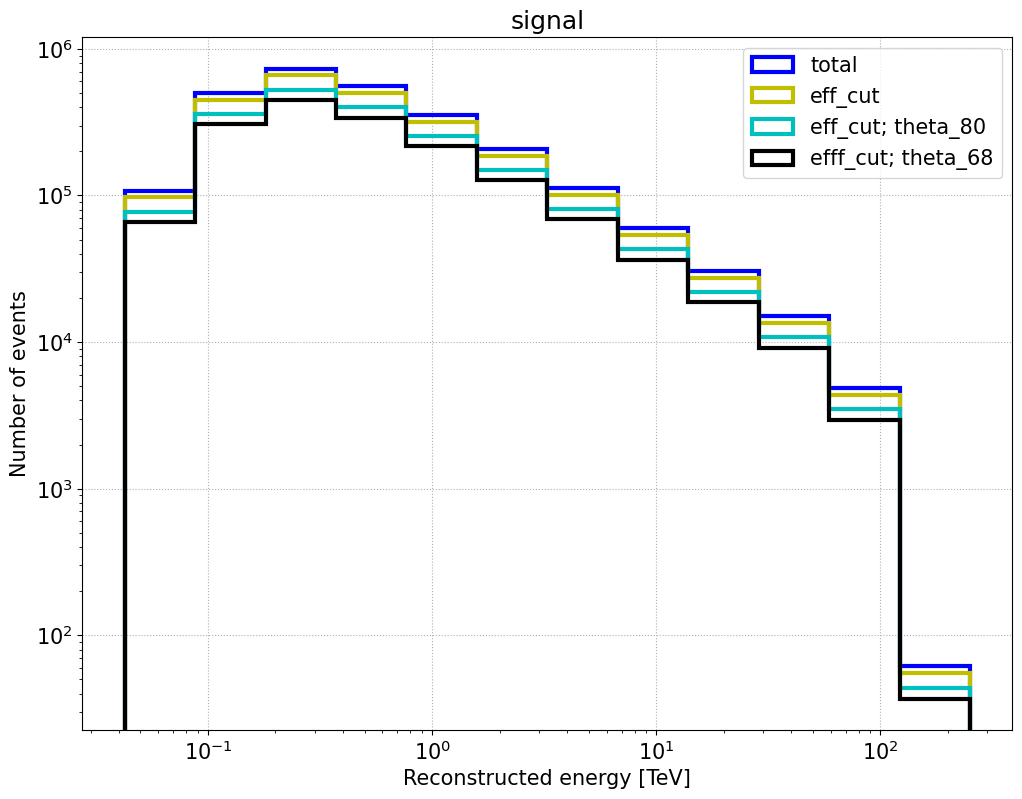

In [153]:
plt.figure()
plt.title("signal")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel("Number of events")
plt.semilogx()
plt.yscale(yscale)
plt.grid()

theta_80_eff_sig=np.array(sig_theta_cut_eff_80["reco_energy"].value)
theta_68_eff_sig=np.array(sig_theta_cut_eff_68["reco_energy"].value)
gn_eff_sig=np.array(sig_gn_cut_eff["reco_energy"].value)
sE=np.array(signal_hist["reco_energy"].value)
# before cuts
plt.hist(
    sE,
    bins=energy_bins,
    label="total",
    histtype="step",
    linewidth=3,
    color="b"
)




#gammaness cut
plt.hist(
    gn_eff_sig,
    bins=energy_bins,
    label="eff_cut",
    histtype="step",
    linewidth=3,
    color="y"
)

#theta 80%, eff
plt.hist(
    theta_80_eff_sig,
    bins=energy_bins,
    label="eff_cut; theta_80",
    histtype="step",
    linewidth=3,
    color="c"
)
#theta 68%, eff
plt.hist(
    theta_68_eff_sig,
    bins=energy_bins,
    label="efff_cut; theta_68",
    histtype="step",
    linewidth=3,
    color="k"
)
plt.legend()
